# 画像生成AIをつくろう（GAN編）

In [246]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [8]:
# 識別機は入力を受け取り、それが本物か偽物かを判定する
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)

        logit_out = self.fc4(x)

        return logit_out

In [16]:
# 生成機はランダムノイズを受け取り、それを元に本物のデータに似たデータを生成する
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)

        x = self.fc4(x)
        tanh_out = self.tanh(x) # -1から1を出力

        return tanh_out

In [ ]:
# 損失関数
def real_loss(predicted, loss_function, device):
    """
    入力が本物(==1)のデータの場合の損失関数
    """
    batch_size = predicted.shape[0]
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_function(predicted.squeeze(), targets)
    return real_loss

def fake_loss(predicted, loss_function, device):
    """
    入力が偽物(==0)のデータの場合の損失関数
    """
    batch_size = predicted.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_function(predicted.squeeze(), targets)
    return fake_loss

In [7]:
def train(discriminator,
          generator,
          discriminator_optimizer,
          generator_optimizer,
          loss_function,
          data_loader,
          number_of_epochs,
          device,
          verbose=False):

    # 生成器の入力として使用する潜在空間z
    batch = 16
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(batch, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)

    fixed_samples = []

    discriminator_losses = []
    generator_losses = []

    discriminator = discriminator.to(device)
    generator = generator.to(device)

    for epoch in range(number_of_epochs):
        print(f"エポック {epoch + 1}/{number_of_epochs}")
        discriminator.train()
        generator.train()
        discriminator_running_batch_loss = 0
        generator_running_batch_loss = 0
        for current_batch_index, (real_image, _) in enumerate(data_loader):
            # 1-1. 識別器の最適化関数の勾配を初期化
            discriminator_optimizer.zero_grad()

            # 1-2. 本物の画像で識別して誤差を計算
            real_image = real_image.to(device)
            real_image = (real_image * 2) - 1 # 0〜1の値を-1〜1の値に変換
            real_predicted = discriminator(real_image)
            discriminator_real_loss = real_loss(real_predicted, loss_function, device)

            # 1-3. 偽物の画像を識別して誤差を計算
            with torch.no_grad():
                # 潜在空間のベクトルを生成
                z = np.random.uniform(-1, 1, size=(data_loader.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # 生成器で偽物の画像を生成
                fake_images = generator(z)
            
            fake_predicted = discriminator(fake_images)
            discriminator_fake_loss = fake_loss(fake_predicted, loss_function, device)

            # 1-4. 誤差を合計
            discriminator_loss = discriminator_real_loss + discriminator_fake_loss

            # 1-5. 誤差を逆伝播
            discriminator_loss.backward()

            # 1-6. 識別器のパラメータを更新
            discriminator_optimizer.step()

            # 誤差をログに記録
            discriminator_running_batch_loss += discriminator_loss.item()

            # 2-1. 生成器の最適化関数の勾配を初期化
            generator_optimizer.zero_grad()

            # 2-2. 偽の画像を生成して識別器で識別 
            z = np.random.uniform(-1, 1, size=(data_loader.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            fake_images = generator(z)
            fake_predicted = discriminator(fake_images)
            generator_loss = real_loss(fake_predicted, loss_function, device)

            # 2-3. 誤差を逆伝播
            generator_loss.backward()

            # 2-4. 生成器のパラメータを更新
            generator_optimizer.step()

            # 2-5. 誤差をログに記録
            generator_running_batch_loss += generator_loss.item()

            # 100バッチごとにログを表示
            if current_batch_index % 100 == 0 and verbose:
                batch_log = f"バッチ {current_batch_index}/{len(data_loader)}"
                discriminator_batch_log = f"識別器の誤差 {discriminator_loss.item():.6f}"
                generator_batch_log = f"生成器の誤差 {generator_loss.item():.6f}"
                print(f"{batch_log} {discriminator_batch_log} {generator_batch_log}")

        # エポックごとの誤差をログに記録
        discriminator_epoch_loss = discriminator_running_batch_loss / len(data_loader)
        generator_epoch_loss = generator_running_batch_loss / len(data_loader)
        discriminator_losses.append(discriminator_epoch_loss)
        generator_losses.append(generator_epoch_loss)

        # エポックごとにログを表示
        epoch_log = f"エポック {epoch + 1}/{number_of_epochs}"
        discriminator_epoch_log = f"識別器の誤差 {discriminator_epoch_loss:.6f}"
        generator_epoch_log = f"生成器の誤差 {generator_epoch_loss:.6f}"
        print(f"{epoch_log} {discriminator_epoch_log} {generator_epoch_log}")

        # ログ用に偽の画像を生成して保存
        generator.eval()
        fixed_samples.append(generator(fixed_z).detach().cpu())

    # ログ用に生成した偽の画像を保存
    with open("fixed_samples.pkl", "wb") as f:
        pkl.dump(fixed_samples, f)

    return discriminator_losses, generator_losses

In [17]:
# ニューラルネットワークのパラメータを初期化
discriminator = Discriminator(in_features=28*28, out_features=1)
generator = Generator(in_features=100, out_features=28*28)

# 最適化関数のパラメータを初期化
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.002)

# バイナリクロスエントロピーを誤差関数に使用
loss_function = nn.BCEWithLogitsLoss()

# GPUがある場合はcudaを使い、ない場合はcpuを使う
device = "cuda" if torch.cuda.is_available() else "cpu"

# エポック数
number_of_epochs = 100

# 学習開始
discriminator_losses, generator_losses = train(discriminator,
                                               generator,
                                               discriminator_optimizer,
                                               generator_optimizer,
                                               loss_function,
                                               data_loader,
                                               number_of_epochs,
                                               device,
                                               verbose=True)


エポック 1/100
バッチ 0/938 識別器の誤差 1.388194 生成器の誤差 0.759508
バッチ 100/938 識別器の誤差 0.492427 生成器の誤差 2.108023
バッチ 200/938 識別器の誤差 1.508437 生成器の誤差 0.772780
バッチ 300/938 識別器の誤差 1.382276 生成器の誤差 0.544350
バッチ 400/938 識別器の誤差 1.319223 生成器の誤差 0.679657
バッチ 500/938 識別器の誤差 1.384734 生成器の誤差 0.629999
バッチ 600/938 識別器の誤差 1.388922 生成器の誤差 1.452258
バッチ 700/938 識別器の誤差 0.570290 生成器の誤差 5.730203
バッチ 800/938 識別器の誤差 1.422873 生成器の誤差 0.550567
バッチ 900/938 識別器の誤差 1.470448 生成器の誤差 0.967283
エポック 1/100 識別器の誤差 1.175357 生成器の誤差 1.812988
エポック 2/100
バッチ 0/938 識別器の誤差 1.504416 生成器の誤差 0.772393
バッチ 100/938 識別器の誤差 0.867080 生成器の誤差 1.523961
バッチ 200/938 識別器の誤差 1.204288 生成器の誤差 2.005045
バッチ 300/938 識別器の誤差 1.443016 生成器の誤差 0.820845
バッチ 400/938 識別器の誤差 0.878453 生成器の誤差 2.332715
バッチ 500/938 識別器の誤差 1.184960 生成器の誤差 0.699947
バッチ 600/938 識別器の誤差 0.775747 生成器の誤差 2.420726
バッチ 700/938 識別器の誤差 1.076419 生成器の誤差 1.121075
バッチ 800/938 識別器の誤差 1.443203 生成器の誤差 0.794522
バッチ 900/938 識別器の誤差 1.204889 生成器の誤差 0.877839
エポック 2/100 識別器の誤差 1.165125 生成器の誤差 1.468098
エポック 3/100
バッチ 0

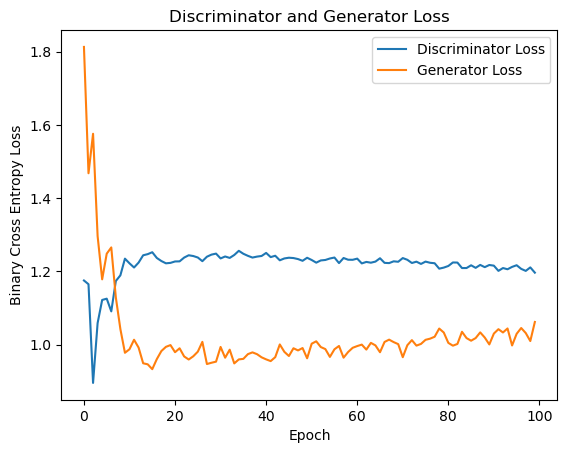

In [ ]:
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.plot(generator_losses, label="Generator Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Discriminator and Generator Loss")
plt.show()

In [79]:
with open("fixed_samples.pkl", "rb") as f:
    samples = pkl.load(f)

def view_samples(epoch):
    print(f"エポック{epoch}の生成画像")
    s = samples[epoch - 1]
    s = (s + 1) / 2 # -1〜1の値を0〜1の値に変換
    for i in range(len(s)):
        image = s[i].view(28, 28).detach().numpy()
        axes = plt.subplot(4, 4, i + 1)
        axes.imshow(image, cmap="gray")
        axes.axis("off")

エポック1の生成画像


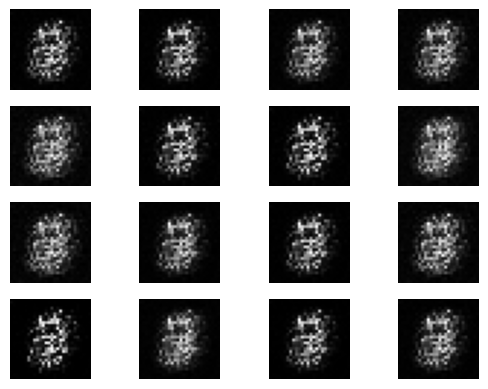

In [81]:
view_samples(1)

エポック50の生成画像


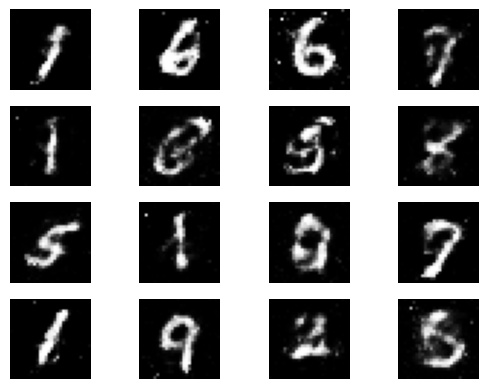

In [82]:
view_samples(50)

エポック100の生成画像


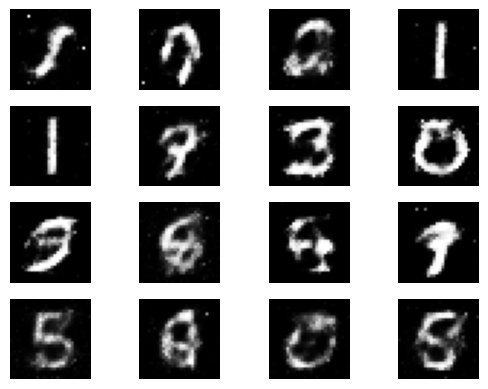

In [80]:
view_samples(100)

本物である確率: 34%


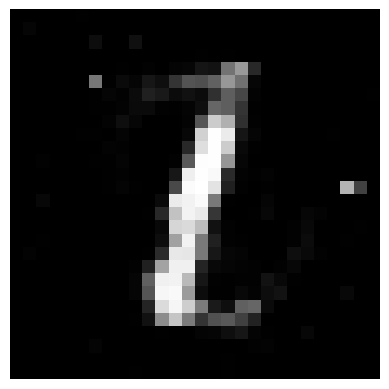

In [245]:
generator.to("cpu")
generator.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = generator(z)

# 生成した画像を表示
image = (fake_image + 1) / 2 # -1〜1の値を0〜1の値に変換
image = image.view(28, 28).detach().numpy()
plt.imshow(image, cmap="gray")
plt.axis("off")

# 生成した画像が本物である確率を計算
discriminator.to("cpu")
discriminator.eval()
result = discriminator(fake_image.view(1, 28*28))
result = torch.sigmoid(result).item()
print(f"本物である確率: {int(result * 100)}%")